In [1]:
import cv2 
import numpy as np
from skimage import data, io, color, transform, exposure
import os
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from threading import Thread
from queue import Queue
import json
from pprint import pprint
import time
import operator
import copy
from collections import Counter
import scipy
from scipy import ndimage
from scipy import misc
import scipy.misc

class FileVideoStream:
    def __init__(self, path, queueSize = 1024):
        self.stream = cv2.VideoCapture(path)
        self.stopped = False
        self.Q = Queue(maxsize = queueSize)
        
    def start(self):
        t = Thread(target = self.update, args = ())
        t.daemon = True
        t.start()
        return self
    
    def update(self):
        while True:
            if self.stopped:
                return
            
            if not self.Q.full():
                (grabbed, frame) = self.stream.read()
                if not grabbed:
                    self.stop()
                    return
                
                self.Q.put(frame)
    def read(self):
        return self.Q.get()
    
    def more(self):
        return self.Q.qsize() > 0
    
    def stop(self):
        self.stopped = True


In [2]:
def findmaximumpeople(json_folder_dir, jsons, id0, idn):
    
    if not id0 == idn:
        midval = (id0 + idn)//2
        leftval = findmaximumpeople(json_folder_dir, jsons, id0, midval)
        rightval = findmaximumpeople(json_folder_dir, jsons, midval + 1, idn)
        
        if leftval >= rightval:
            return leftval
        else:
            return rightval
    else:
        with open((json_folder_dir + jsons[id0])) as f:
            data = json.load(f)
        
        total_number_of_people = len(data['people'])

                
        return(total_number_of_people)
    

In [3]:
def data_points(jsons, json_folder_dir):
    data_points = []
    
    for i in range(0, len(jsons)):
        data_points.append([])
        with open((json_folder_dir + jsons[i])) as f:
            data = json.load(f)
        
        n_people = len(data['people'])
    
        for j in range(0, n_people):
            data_points[i].append([])
            datas = data['people'][j]['pose_keypoints_2d']
        
            for k in range(0, len(datas)):
                data_points[i][j].append(datas[k])
                
    return data_points

In [4]:
def data_classification(data):
    body_label = {0:"Nose", 1:"Neck", 2:"RShoulder", 3:"RElbow", 4:"RWrist", 5:"LShoulder", 6:"LElbow", 7:"LWrist", 8:"MidHip", 9:"RHip", 10:"RKnee", 11:"RAnkle", 12:"LHip", 13:"LKnee",14:"LAnkle", 15:"REye", 16:"LEye", 17:"REar", 18:"LEar", 19:"LBigToe", 20:"LSmallToe", 21:"LHeel", 22:"RBigToe", 23:"RSmallToe", 24:"RHeel"}
    parts = {}
    people = {}
    
    for person in range(0, len(data)):
        points = data[person]
        for i in range(0, len(points)):
            parts[body_label[i]] = points[i]
        
        people[person] = parts
        parts = {}
        
    return people

In [5]:
def organise_data(data):
    total = len(data)
    people_body_point = {}
    
    for i in range(0, total):
        people = len(data[i])
        frame_points = {}
        if people != 0:
            for j in range(0, people):
                points = data[i][j]
                n_points = len(points)
                body_points = []
                for k in range(0, n_points - 1, 3):
                    item = int(k/3)
                    body_points.append((points[0 + k], points[1 + k]))
                    
                frame_points[j] = body_points
            
            organised = data_classification(frame_points)
            people_body_point[i] = organised
        
    return people_body_point

In [6]:
def plot_box(file, data):
    loading = False
    
    fvs = FileVideoStream(file).start()
    
    i = 0
    
    while not fvs.more():
        if not loading:
            print("Loading")
            loading = True
    
    while fvs.more():
        frame = fvs.read()
        
        if i in data:
            people = len(data[i])
            for j in range(0, people):
                tmp_points = copy.deepcopy(data[i][j])
                x_points = copy.deepcopy(data[i][j])                
                y_points = {}
                for point in tmp_points:
                    if x_points[point][0] == 0:
                        del x_points[point]
                    
                    if tmp_points[point][1] != 0:
                        y_points[point] = tmp_points[point][1]
                        
                        
                minY = min(y_points.items(), key = operator.itemgetter(1))[1]
                maxY = max(y_points.items(), key = operator.itemgetter(1))[1]
                

                maxX, GY = max(x_points.items(), key = operator.itemgetter(1))[1]
                minX, GY = min(x_points.items(), key = operator.itemgetter(1))[1]
                
                minY = int(minY)
                maxY = int(maxY)
                minX = int(minX)
                maxX = int(maxX)
                
                cv2.rectangle(frame, (minX, minY), (maxX, maxY), (0, 255, 0), 3)
        
        cv2.imshow("Video", frame)    
        i += 1
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
                    
    
    fvs.stop()
    cv2.destroyAllWindows()
    

In [7]:
def only_people_and_release(file, data, output):
    loading = False
    
    fvs = cv2.VideoCapture(file)
    
    video = cv2.VideoWriter(output,cv2.VideoWriter_fourcc(*"MJPG"), 30, (1920,1080),True)
    
    i = 0
        
    all_frame = {}
    
    success, frame = fvs.read()
    
    initial_frame = np.zeros((frame.shape), dtype=np.uint8)
                    
    while success:
        
        output_frame = copy.deepcopy(initial_frame)
        
        if i in data:
            people = len(data[i])
            for j in range(0, people):
                tmp_points = copy.deepcopy(data[i][j])
                x_points = copy.deepcopy(data[i][j])                
                y_points = {}
                total_del = 0
                for point in tmp_points:
                    if x_points[point][0] == 0:
                        del x_points[point]
                        total_del += 1
                    
                    if tmp_points[point][1] != 0:
                        y_points[point] = tmp_points[point][1]
                        
                if total_del > 15:
                    continue
                        
                        
                minY = min(y_points.items(), key = operator.itemgetter(1))[1]
                maxY = max(y_points.items(), key = operator.itemgetter(1))[1]
                

                maxX, GY = max(x_points.items(), key = operator.itemgetter(1))[1]
                minX, GY = min(x_points.items(), key = operator.itemgetter(1))[1]
                
                minY = int(minY)
                maxY = int(maxY)
                minX = int(minX)
                maxX = int(maxX)
                
                for y in range(minY, maxY):
                    for x in range(minX, maxX):
                        output_frame[y][x] = frame[y][x]
                        
        hsv = cv2.cvtColor(output_frame, cv2.COLOR_BGR2HSV)
        video.write(hsv)
        i += 1
            
        success, frame = fvs.read()
    
    video.release()
    print("Released")
    

In [8]:
def plot_box_and_release(file, data, output):
    loading = False
    
    video = cv2.VideoWriter(output,cv2.VideoWriter_fourcc(*"MJPG"), 30, (1920,1080),True)
    
    fvs = FileVideoStream(file).start()
    
    i = 0
    
    while not fvs.more():
        if not loading:
            print("Loading")
            loading = True
    
    while fvs.more():
        frame = fvs.read()
        
        if i in data:
            people = len(data[i])
            for j in range(0, people):
                tmp_points = copy.deepcopy(data[i][j])
                x_points = copy.deepcopy(data[i][j])                
                y_points = {}
                for point in tmp_points:
                    if x_points[point][0] == 0:
                        del x_points[point]
                    
                    if tmp_points[point][1] != 0:
                        y_points[point] = tmp_points[point][1]
                        
                        
                minY = min(y_points.items(), key = operator.itemgetter(1))[1]
                maxY = max(y_points.items(), key = operator.itemgetter(1))[1]
                

                maxX, GY = max(x_points.items(), key = operator.itemgetter(1))[1]
                minX, GY = min(x_points.items(), key = operator.itemgetter(1))[1]
                
                minY = int(minY)
                maxY = int(maxY)
                minX = int(minX)
                maxX = int(maxX)
                
                cv2.rectangle(frame, (minX, minY), (maxX, maxY), (0, 255, 0), 3)
        
        video.write(frame)
        cv2.imshow("Video", frame)    
        i += 1
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
                    
    
    fvs.stop()
    video.release()
    cv2.destroyAllWindows()
    print("Released")

In [9]:
def read_jsons(folder):
    jsons = [json for json in os.listdir(folder) if json.endswith(".json")]
    
    return jsons

In [10]:
def plot_data_points_and_release(file, data, output):
    i = 0

    loading = False

    video = cv2.VideoWriter(output,cv2.VideoWriter_fourcc(*"MJPG"), 30, (1920,1080),True)

    fvs = FileVideoStream(file).start()

    while not fvs.more():
        if not loading:
            print("Loading")
            loading = True

    while fvs.more():
        frame = fvs.read()
        people = len(data[i])
        if people != 0:
            for j in range(0, people):
                points = data[i][j]
                n_points = len(points)
                div = n_points // 3
                for k in range(0, div):
                    if int(points[0 + 3 * k]) != 0 and int(points[1 + 3 * k]) != 0:
                        cv2.putText(frame, str([points[0 + 3 * k], points[1 + 3 * k]]),(int(points[0 + 3 * k]) - 10,int(points[1 + 3 * k])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1,cv2.LINE_AA)

        video.write(frame)
        cv2.imshow("Video", frame)
        i += 1
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

    fvs.stop()
    cv2.destroyAllWindows()
    video.release()
    print("Released")

In [11]:
def plot_data_points(file, data):
    i = 0

    loading = False

    fvs = FileVideoStream(file).start()

    while not fvs.more():
        if not loading:
            print("Loading")
            loading = True

    while fvs.more():
        frame = fvs.read()
        people = len(data[i])
        if people != 0:
            for j in range(0, people):
                points = data[i][j]
                n_points = len(points)
                div = n_points // 3
                for k in range(0, div):
                    if int(points[0 + 3 * k]) != 0 and int(points[1 + 3 * k]) != 0:
                        cv2.putText(frame, str([points[0 + 3 * k], points[1 + 3 * k]]),(int(points[0 + 3 * k]) - 10,int(points[1 + 3 * k])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1,cv2.LINE_AA)

        cv2.imshow("Video", frame)
        i += 1
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

    fvs.stop()
    cv2.destroyAllWindows()

In [12]:
def get_dominant_color(image, k=4, image_processing_size = None):

    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)

In [13]:
def only_people(file, data):
    loading = False
    
    fvs = cv2.VideoCapture(file)
    
    i = 0
        
    success, frame = fvs.read()
                    
    for i in range(100):
#     while success:
                
        if i in data:
            people = len(data[i])
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            for j in range(0, people):
                tmp_points = copy.deepcopy(data[i][j])
                x_points = copy.deepcopy(data[i][j])                
                y_points = {}
                total_del = 0
            
                for point in tmp_points:
                    if x_points[point][0] == 0:
                        del x_points[point]
                        total_del += 1
                    
                    if tmp_points[point][1] != 0:
                        y_points[point] = tmp_points[point][1]
                        
                if total_del > 15:
                    continue
                        
                        
                minY = min(y_points.items(), key = operator.itemgetter(1))[1]
                maxY = max(y_points.items(), key = operator.itemgetter(1))[1]
                

                maxX, GY = max(x_points.items(), key = operator.itemgetter(1))[1]
                minX, GY = min(x_points.items(), key = operator.itemgetter(1))[1]
                
                minY = int(minY)
                maxY = int(maxY)
                minX = int(minX)
                maxX = int(maxX)
                                
                person_frame = np.zeros(((maxY - minY), (maxX - minX), 3), dtype = np.uint8)
                for y in range(minY, maxY):
                    for x in range(minX, maxX):
                            person_frame[y - minY][x - minX] = hsv[y][x]
                
#                 print("Frame")
#                 pprint(frame)
#                 print("Person frame")
#                 pprint(tmp_points)
                plt.imshow(person_frame)
                plt.show()
#                 hsv = cv2.cvtColor(person_frame, cv2.COLOR_BGR2HSV)
                        
#                 plt.imshow(hsv)
#                 plt.show()
                
        i += 1 
            
        success, frame = fvs.read()

In [37]:
def masked(file, data, start):
    loading = False
    
    fvs = cv2.VideoCapture(file)
    
    for k in range(start):
        success, frame = fvs.read()
    
    if start == 0:
        success, frame = fvs.read()
            
#     i = 0
    
    id_color = []
    
    for i in range(start, start + 2000):
#     while success:
        
        id_with_color = {}
                
        if i in data:
            people = len(data[i])
            hsv = cv2.cvtColor(cv2.medianBlur(frame, 5), cv2.COLOR_BGR2HSV)

            for j in range(0, people):
                tmp_points = copy.deepcopy(data[i][j])
                x_points = copy.deepcopy(data[i][j])                
                y_points = {}
                total_del = 0
            
                for point in tmp_points:
                    if x_points[point][0] == 0:
                        del x_points[point]
                        total_del += 1
                    
                    if tmp_points[point][1] != 0:
                        y_points[point] = tmp_points[point][1]
                        
                if total_del > 15:
                    continue
                        
                neck = copy.deepcopy(tmp_points['Neck'])
                midHip = copy.deepcopy(tmp_points['MidHip'])
                
                midX = int((neck[0] + midHip[0])/2)
                midY = int((neck[1] + midHip[1])/2)
                
#                 minY = min(y_points.items(), key = operator.itemgetter(1))[1]
#                 maxY = max(y_points.items(), key = operator.itemgetter(1))[1]
                

#                 maxX, GY = max(x_points.items(), key = operator.itemgetter(1))[1]
#                 minX, GY = min(x_points.items(), key = operator.itemgetter(1))[1]
                
#                 minY = int(minY)
#                 maxY = int(maxY)
#                 minX = int(minX)
#                 maxX = int(maxX)
                
                id_color.append([frame[midY][midX]])
                                
#                 person_frame = np.zeros(((maxY - minY), (maxX - minX), 3), dtype = np.uint8)
#                 for y in range(minY, maxY):
#                     for x in range(minX, maxX):
#                             person_frame[y - minY][x - minX] = hsv[y][x]
                
#                 print("Frame")
#                 pprint(frame)
#                 print("Person frame")
#                 pprint(person_frame)
                
                
#                 for l, col in enumerate(['b', 'g', 'r']):
#                     hist = cv2.calcHist([person_frame], [l], None, [256], [0, 256])
#                     plt.plot(hist, color=col)
# #                     plt.xlim([0, 256])
                        
#                 plt.show()
                
#                 plt.imshow(person_frame)  
#                 plt.scatter((midX - minX), (midY - minY))
#                 plt.show()
#                 print(person_frame[midY-minY][midX-minX])
                                    
#                 plt.imshow(hist)
#                 plt.show()
#                 hsv = cv2.cvtColor(person_frame, cv2.COLOR_BGR2HSV)
                        
#                 plt.imshow(hsv)
#                 plt.show()

        i+= 1
                            
        success, frame = fvs.read()
    
    
    for l, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([np.asarray(id_color)], [l], None, [256], [0, 256])
        plt.plot(hist, color=col)
#         plt.xlim([0, 60])

In [15]:
json_folder = 'DS3'
json_folder_slash = 'DS3/'

jsons = read_jsons(json_folder)

number_of_people = findmaximumpeople(json_folder_slash, jsons, 0, (len(jsons) - 1))

data_points1 = data_points(jsons, json_folder_slash)

In [16]:
people_body_part_points = organise_data(data_points1)

In [17]:
# pprint(people_body_part_points)
print(number_of_people)

4


In [18]:
point = people_body_part_points[16][1]
print(max(point.items(), key = operator.itemgetter(1))[1])
print(min(point.items(), key = operator.itemgetter(1))[1])

(745.202, 954.222)
(0, 0)


In [19]:
# plot_data_points('result2.mp4', data_points1)

In [20]:
# plot_box('result2.mp4', people_body_part_points)

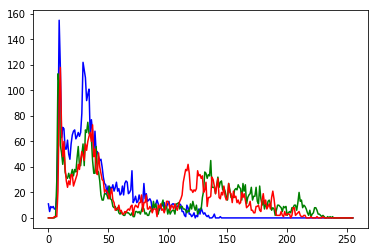

In [38]:
masked('DS2.MOV', people_body_part_points, 0)

In [45]:
cap = cv2.VideoCapture('DS2.MOV')

while(1):
    ret, frame = cap.read()
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
#     lower_range = np.array([0, 0, 0])
#     upper_range = np.array([30, 50, 50])

    lower_range = np.array([30, 120, 100])
    upper_range = np.array([50, 255, 255])

    mask = cv2.inRange(hsv, lower_range, upper_range)
    
    cv2.imshow('frame',mask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
        
cap.release()
cv2.destroyAllWindows()